# Model Training, Evaluation, and Explanation (for Both Datasets)

In [1]:
# Imports
import os
import random
import time
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from loaders import load_ratings
from sklearn.metrics import mean_squared_error
from surprise import accuracy

import json
# 
from models import ContentBased as DefaultContentBased
from models_hackaton import ContentBased as HackathonContentBased
from constants import Constant as C


In [2]:
# Create folders
os.makedirs("models", exist_ok=True)
os.makedirs("visualizations", exist_ok=True)
# os.makedirs("evaluation", exist_ok=True)
os.makedirs("evaluation/results", exist_ok=True)


In [3]:
# Dataset selection
DATASETS = {
    'normal': load_ratings(surprise_format=True),
    'hackathon': load_ratings(surprise_format=True, hack=True),
}

# Save trainsets
for name, data in DATASETS.items():
    trainset = data.build_full_trainset()
    joblib.dump(trainset, f"models/trainset_{name}.pkl")
    DATASETS[name] = trainset


In [ ]:
# Define combinations
COMBINATIONS = {
    'normal': [
        ("all_features", "linear_regression"),
        ("all_features", "random_forest"),
        ("all_features", "xgboost"),
        ("all_features", "neural_network")
    ],
    'hackathon': [
        ("genome_tags", "linear_regression"),
        ("genome_tags", "random_forest"),
        ("genome_tags", "xgboost"),
        ("genome_tags", "neural_network"),
        ("all_features_with_genome", "linear_regression"),
        ("all_features_with_genome", "random_forest"),
        ("all_features_with_genome", "xgboost"),
        ("all_features_with_genome", "neural_network"),
        # ("all_features_with_genome_and_visuals", "linear_regression"),
        # ("all_features_with_genome_and_visuals", "random_forest"),
        # ("all_features_with_genome_and_visuals", "xgboost"),
        # ("all_features_with_genome_and_visuals", "neural_network")
    ]
}


In [5]:
results_filename = C.EVALUATION_PATH / "results/all_results.json"  
all_results = []

# Train, evaluate, and explain
for dataset_name, combinations in COMBINATIONS.items():
    trainset = DATASETS[dataset_name]

    # Choix du bon ContentBased
    ContentBased = HackathonContentBased if dataset_name == "hackathon" else DefaultContentBased

    for features_method, regressor_method in combinations:
        try:
            print(f"\n{'='*50}")
            print(f"Test with {features_method} and {regressor_method} on {dataset_name}")
            print(f"{'='*50}")

            model_filename = f"models/model_{dataset_name}_{features_method}_{regressor_method}.pkl"

            # Charger modèle existant si présent
            if os.path.exists(model_filename):
                print("✅ Model already trained. Loading from file.")
                model = joblib.load(model_filename)
                duration = 0.0
            else:
                print("🔁 Training new model...")
                start = time.time()
                model = ContentBased(features_method=features_method, regressor_method=regressor_method)
                model.fit(trainset)
                duration = time.time() - start
                joblib.dump(model, model_filename)

            predictions = model.test(testset=trainset.build_testset())
            true_ratings = [r for (_, _, r) in trainset.all_ratings()]
            rmse = accuracy.rmse(predictions, verbose=False)
            mae = accuracy.mae(predictions, verbose=False)

            result = {
                'dataset': dataset_name,
                'features_method': features_method,
                'regressor_method': regressor_method,
                'RMSE': rmse,
                'MAE': mae,
                'TrainTime': duration
            }
            all_results.append(result)

            # 💾 Sauvegarder les résultats après chaque modèle
            with open(results_filename, 'w') as f:
                json.dump(all_results, f, indent=4)

            # Explication globale
            print("\nTop global features:")
            global_importances = model.get_global_feature_importance(top_n=10)
            for feature, importance in global_importances.items():
                print(f"{feature}: {importance:.4f}")

            model.visualize_global_feature_importance(
                top_n=10,
                save_path=f"visualizations/global_importance_{dataset_name}_{features_method}_{regressor_method}.png"
            )

            # Explication utilisateur
            user_id = 14
            print(f"\nExplanation for user {user_id}:")
            explanations = model.explain(user_id)
            if explanations:
                sorted_explanations = sorted(explanations.items(), key=lambda x: x[1], reverse=True)
                for feature, score in sorted_explanations[:10]:
                    print(f"{feature}: {score:.4f}")

                model.visualize_feature_correlation(
                    user_id,
                    save_path=f"visualizations/correlation_matrix_{dataset_name}_{features_method}_{regressor_method}_user_{user_id}.png"
                )
            else:
                print("No explanation available for this user")

        except Exception as e:
            print(f"❌ Error with {dataset_name} / {features_method} / {regressor_method}: {e}")
            # Sauvegarde même en cas d'erreur
            with open(results_filename, 'w') as f:
                json.dump(all_results, f, indent=4)


Test with all_features_with_genome and linear_regression on hackathon
🔁 Training new model...


c:\Users\nicol\env_py312\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(



Top global features:
genre_Animation_popularity: 0.6855
tfidf_animation: 0.6519
tfidf_musical: 0.5588
tfidf_western: 0.5453
genre_Musical_popularity: 0.5451
genre_Children_popularity: 0.5380
tfidf_film-noir: 0.5244
genre_Film-Noir_popularity: 0.5163
tfidf_children: 0.5104
genre_Western_popularity: 0.5074

Explanation for user 14:
genre_Animation_popularity: 1.0000
genre_War_popularity: 0.9009
tfidf_animation: 0.8738
tfidf_comedy: 0.8734
tfidf_adventure: 0.7964
tfidf_action: 0.7381
tfidf_thriller: 0.7273
tfidf_drama: 0.7229
tfidf_sci-fi: 0.6223
tfidf_war: 0.6014
❌ Error with hackathon / all_features_with_genome / linear_regression: name 'sns' is not defined

Test with all_features_with_genome_and_visuals and linear_regression on hackathon
🔁 Training new model...


c:\Users\nicol\env_py312\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


❌ Error with hackathon / all_features_with_genome_and_visuals / linear_regression: 'movieId'

Test with all_features_with_genome_and_visuals and random_forest on hackathon
🔁 Training new model...


c:\Users\nicol\env_py312\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


❌ Error with hackathon / all_features_with_genome_and_visuals / random_forest: 'movieId'

Test with all_features_with_genome_and_visuals and xgboost on hackathon
🔁 Training new model...


c:\Users\nicol\env_py312\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


❌ Error with hackathon / all_features_with_genome_and_visuals / xgboost: 'movieId'

Test with all_features_with_genome_and_visuals and neural_network on hackathon
🔁 Training new model...


c:\Users\nicol\env_py312\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


❌ Error with hackathon / all_features_with_genome_and_visuals / neural_network: 'movieId'


<Figure size 1200x1000 with 0 Axes>

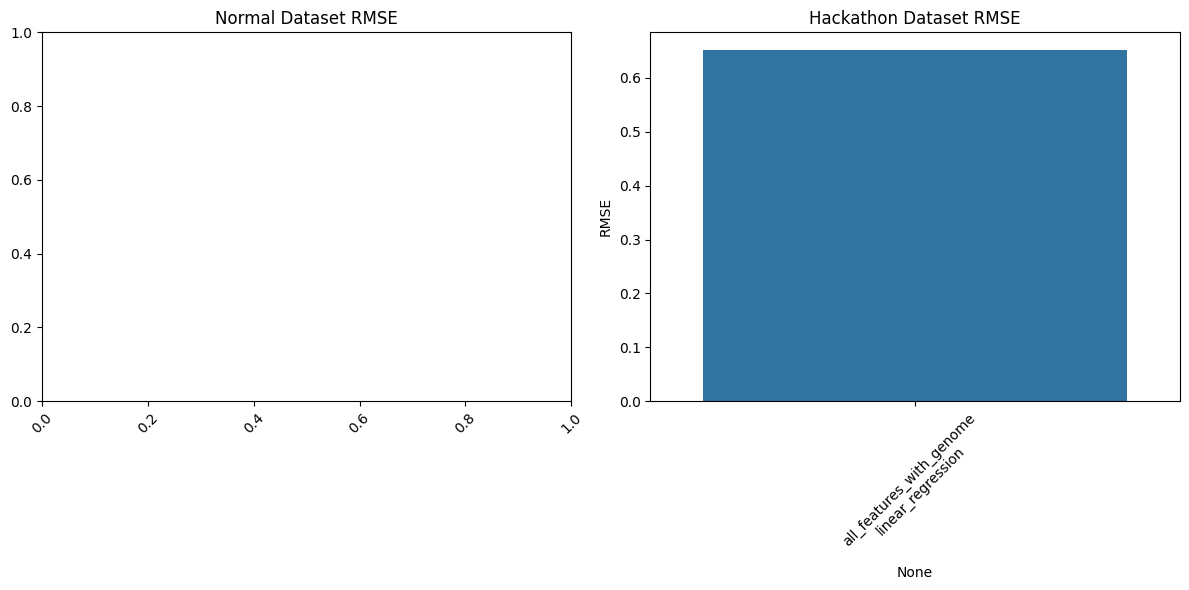

In [6]:
# Save evaluation results
results_df = pd.DataFrame(all_results)
results_df.to_csv("evaluation/results_all.csv", index=False)

normal_df = results_df[results_df['dataset'] == 'normal'].copy()
hackathon_df = results_df[results_df['dataset'] == 'hackathon'].copy()

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.barplot(x=normal_df['features_method'] + '\n' + normal_df['regressor_method'], y='RMSE', data=normal_df)
plt.title('Normal Dataset RMSE')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
sns.barplot(x=hackathon_df['features_method'] + '\n' + hackathon_df['regressor_method'], y='RMSE', data=hackathon_df)
plt.title('Hackathon Dataset RMSE')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

normal_df.to_csv('evaluation/normal_results.csv', index=False)
hackathon_df.to_csv('evaluation/hackathon_results.csv', index=False)
